In [3]:
import gzip
from collections import defaultdict
import numpy as np

def readGz(path):
  for l in gzip.open(path, 'rt'):
    yield eval(l)

def readCSV(path):
  f = gzip.open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')

### Rating baseline: compute averages for each user, or return the global average if we've never seen the user before

allRatings = []
userRatings = defaultdict(list)

for user,book,r in readCSV("train_Interactions.csv.gz"):
  r = int(r)
  allRatings.append(r)
  userRatings[user].append(r)

globalAverage = sum(allRatings) / len(allRatings)
userAverage = {}
for u in userRatings:
  userAverage[u] = sum(userRatings[u]) / len(userRatings[u])

predictions = open("predictions_Rating.csv", 'w')
for l in open("pairs_Rating.csv"):
  if l.startswith("userID"):
    #header
    predictions.write(l)
    continue
  u,b = l.strip().split(',')
  if u in userAverage:
    predictions.write(u + ',' + b + ',' + str(userAverage[u]) + '\n')
  else:
    predictions.write(u + ',' + b + ',' + str(globalAverage) + '\n')

predictions.close()

### Would-read baseline: just rank which books are popular and which are not, and return '1' if a book is among the top-ranked

bookCount = defaultdict(int)
totalRead = 0

for user,book,_ in readCSV("train_Interactions.csv.gz"):
  bookCount[book] += 1
  totalRead += 1

mostPopular = [(bookCount[x], x) for x in bookCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
  count += ic
  return1.add(i)
  if count > totalRead/2: break

predictions = open("predictions_Read.csv", 'w')
for l in open("pairs_Read.csv"):
  if l.startswith("userID"):
    #header
    predictions.write(l)
    continue
  u,b = l.strip().split(',')
  if b in return1:
    predictions.write(u + ',' + b + ",1\n")
  else:
    predictions.write(u + ',' + b + ",0\n")

predictions.close()

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store data
users = []
books = []
ratings = []

# Read data from the CSV file
for user, book, rating in readCSV("train_Interactions.csv.gz"):
    users.append(user)
    books.append(book)
    ratings.append(float(rating))

# Convert lists to NumPy arrays
users_array = np.array(users)
books_array = np.array(books)
ratings_array = np.array(ratings)

# Count frequencies for ratings
unique_ratings, rating_counts = np.unique(ratings_array, return_counts=True)

# Count frequencies for users
unique_users, user_counts = np.unique(users_array, return_counts=True)

# Count frequencies for books
unique_books, book_counts = np.unique(books_array, return_counts=True)

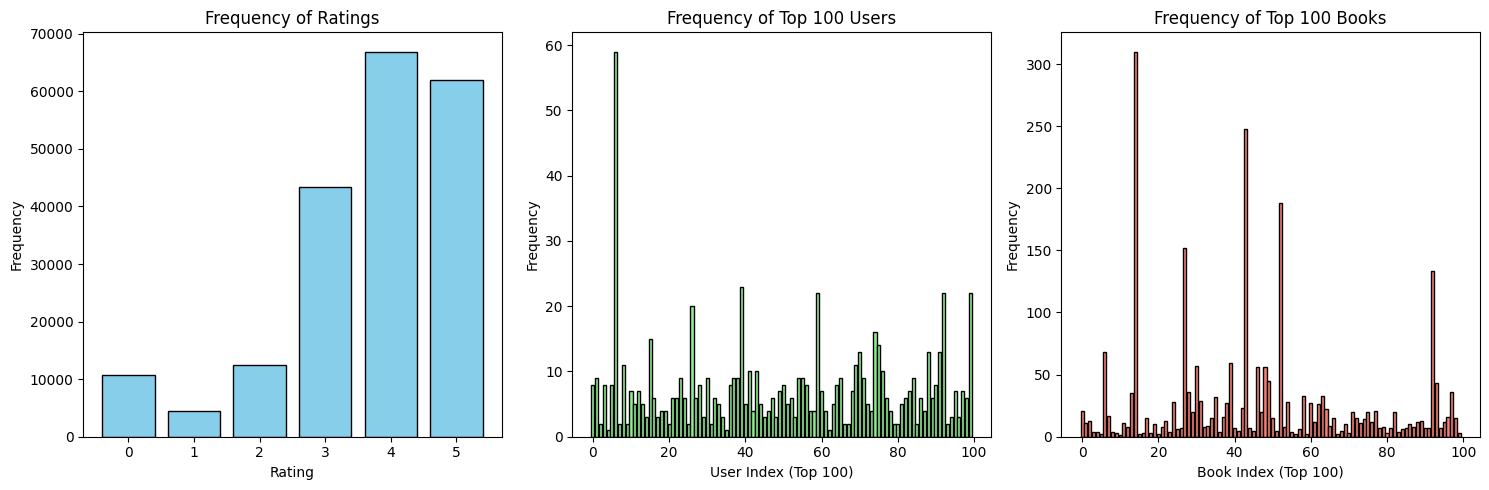

In [10]:
# Plot for ratings
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(unique_ratings, rating_counts, color='skyblue', edgecolor='black')
plt.title('Frequency of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(unique_ratings)  # Set x-ticks to unique ratings

# Plot for users (show top 10 users for clarity)
top_users = unique_users[:100]
top_user_counts = user_counts[:100]
plt.subplot(1, 3, 2)
plt.bar(range(len(top_users)), top_user_counts, color='lightgreen', edgecolor='black')
plt.title('Frequency of Top 100 Users')
plt.xlabel('User Index (Top 100)')
plt.ylabel('Frequency')

# Plot for books (show top 10 books for clarity)
top_books = unique_books[:100]
top_book_counts = book_counts[:100]
plt.subplot(1, 3, 3)
plt.bar(range(len(top_books)), top_book_counts, color='salmon', edgecolor='black')
plt.title('Frequency of Top 100 Books')
plt.xlabel('Book Index (Top 100)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
import gzip
from collections import defaultdict
import random
from sklearn.metrics import mean_squared_error, accuracy_score # Import sklearn metrics

# Helper function to read the data
def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline() # Skip header
    for l in f:
        u,b,r = l.strip().split(',')
        yield u,b,int(r)

# =================================================================
# 1. LOAD AND SPLIT THE DATA
# =================================================================
all_ratings = []
for u, b, r in readCSV("train_Interactions.csv.gz"):
    all_ratings.append((u, b, r))

# Use the same split as the homework
train_set = all_ratings[:190000]
validation_set = all_ratings[190000:]

print(f"Loaded {len(all_ratings)} total interactions.")
print(f"  -> Training set size: {len(train_set)}")
print(f"  -> Validation set size: {len(validation_set)}")

# =================================================================
# 2. "TRAIN" THE PREDICTOR (using ONLY the train_set)
# =================================================================

# Count book frequency *only* in the training set
book_counts_train = defaultdict(int)
for user, book, rating in train_set:
    book_counts_train[book] += 1

# Sort books by popularity
all_books_sorted = sorted(book_counts_train.items(), key=lambda item: item[1], reverse=True)

# Find 50% cutoff
num_unique_books = len(all_books_sorted)
top_50_percent_count = int(num_unique_books * 0.5)

# Create the predictor set
top_50_book_set = set(book_id for book_id, count in all_books_sorted[:top_50_percent_count])

print(f"\nPredictor 'trained' on {len(train_set)} samples.")
print(f"  -> Total unique books in train set: {num_unique_books}")
print(f"  -> Predictor 'top 50%' set contains: {len(top_50_book_set)} books")

# Define the predictor function
def predict_top_50_percent(book_id, top_50_set):
    return 1 if book_id in top_50_set else 0

# =================================================================
# 3. BUILD THE TEST SET (with negative samples)
# =================================================================

# We need all books for negative sampling
all_books_in_data = set(b for u, b, r in all_ratings)
books_per_user = defaultdict(set)
for u, b, r in all_ratings:
    books_per_user[u].add(b)

Loaded 200000 total interactions.
  -> Training set size: 190000
  -> Validation set size: 10000

Predictor 'trained' on 190000 samples.
  -> Total unique books in train set: 6684
  -> Predictor 'top 50%' set contains: 3342 books

Created a test set with 20000 samples.
  -> 10000 positive samples
  -> 10000 negative samples

--- Model Evaluation ---
  sklearn.metrics.mean_squared_error: 0.3061
  sklearn.metrics.accuracy_score:     0.6939 (or 69.39%)

As you can see, accuracy is more interpretable.
This model is correct 69.39% of the time on our test set.


In [12]:
import gzip
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import numpy as np

def readCSV(path):
  f = gzip.open(path, 'rt')
  f.readline() # Skip header
  for l in f:
    yield l.strip().split(',')

# --- 1. Load and Split Data ---
allRatings_data = []
for user,book,r in readCSV("train_Interactions.csv.gz"):
  allRatings_data.append((user, book, int(r)))

# Split into train/validation
train_set = allRatings_data[:190000]
valid_set = allRatings_data[190000:]

# --- 2. Train Model (on train_set ONLY) ---
allRatings_train = []
userRatings_train = defaultdict(list)

for user, book, r in train_set:
  allRatings_train.append(r)
  userRatings_train[user].append(r)

globalAverage = sum(allRatings_train) / len(allRatings_train)
userAverage = {}
for u in userRatings_train:
  userAverage[u] = sum(userRatings_train[u]) / len(userRatings_train[u])

print("--- Rating Model Evaluation (Regression) ---")
print(f"Model trained on {len(train_set)} samples.")

# --- 3. Test Model (on valid_set) ---
y_true = [] # The actual ratings
y_pred = [] # Our model's predictions

for user, book, r_true in valid_set:
    # 'r_true' is the ground truth
    y_true.append(r_true)
    
    # Predict using the model we just trained
    prediction = userAverage.get(user, globalAverage)
    y_pred.append(prediction)

# --- 4. Calculate MSE ---
mse = mean_squared_error(y_true, y_pred)
print(f"Validation MSE: {mse}")
print("A lower MSE is better.")

--- Rating Model Evaluation (Regression) ---
Model trained on 190000 samples.
Validation MSE: 1.5896213021406507
A lower MSE is better.


Data loaded.
Calculating user stats (mean and count)...
               mean  count
userID                    
u00000114  3.250000      8
u00000539  3.555556      9
u00002507  3.000000      2
u00004768  4.125000      8
u00005622  3.000000      1
...             ...    ...
u99979525  4.000000      7
u99987325  3.818182     11
u99990398  0.000000     11
u99994553  3.250000      8
u99994977  4.375000      8

[27945 rows x 2 columns]
Plotting...
Plot saved to user_avg_vs_count_scatter.png


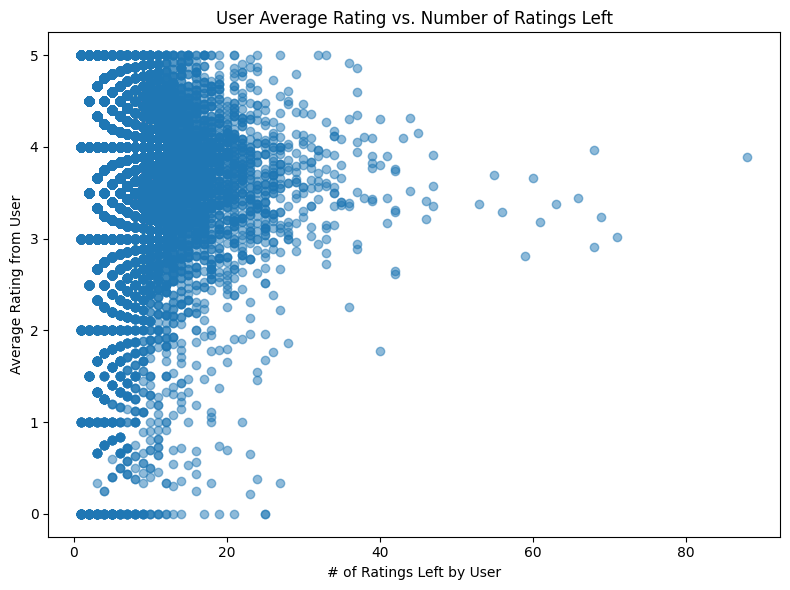

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import io
import os

# --- 1. Load your data into a pandas DataFrame ---
# We'll use the same augmented snippet as before
data_snippet = os.popen("less train_Interactions.csv.gz | cat").read()
# In your real code, you'd use:
# df = pd.read_csv("train_Interactions.csv.gz")
df = pd.read_csv(io.StringIO(data_snippet))
print("Data loaded.")

# --- 2. Calculate Both Metrics at Once ---
# Group by 'userID', then on the 'rating' column,
# aggregate to get both the 'mean' and the 'count'.
print("Calculating user stats (mean and count)...")
user_stats = df.groupby('userID')['rating'].agg(['mean', 'count'])

# user_stats now looks like this:
#
#            mean  count
# userID                    
# u00402241   1.0      1
# u03186275   1.5      2  <-- This user is (x=2, y=1.5)
# u21322233   3.0      1
# u39455611   5.0      1
# u54531895   3.0      2
# u67805239   4.5      2  <-- This user is (x=2, y=4.5)
# u76549666   4.0      1
# u88999268   0.0      1
# u90502882   4.0      1

print(user_stats)

# --- 3. Create the Scatter Plot ---
print("Plotting...")
plt.figure(figsize=(8, 6))

# X-axis is the 'count' column
# Y-axis is the 'mean' column
plt.scatter(user_stats['count'], user_stats['mean'], alpha=0.5)

plt.title('User Average Rating vs. Number of Ratings Left')
plt.xlabel('# of Ratings Left by User')
plt.ylabel('Average Rating from User')

# When you run this on your full 200,000-line file,
# the x-axis will have a "long tail" (most users have 1-5 ratings,
# a few have 100+). You may want to use a log scale to see it better.
#
# plt.xscale('log') # Uncomment this for the full dataset

# --- 4. Save and Show the Plot ---
plt.tight_layout()
plt.savefig("user_avg_vs_count_scatter.png")
print("Plot saved to user_avg_vs_count_scatter.png")
# plt.show()

Data loaded.
Calculating user stats (mean and count)...

Original Stats:
                mean  count
userID                    
u00000114  3.250000      8
u00000539  3.555556      9
u00002507  3.000000      2
u00004768  4.125000      8
u00005622  3.000000      1
...             ...    ...
u99979525  4.000000      7
u99987325  3.818182     11
u99990398  0.000000     11
u99994553  3.250000      8
u99994977  4.375000      8

[27945 rows x 2 columns]

Normalized Stats:
            mean_normalized  count_normalized
userID                                      
u00000114         0.650000          0.080460
u00000539         0.711111          0.091954
u00002507         0.600000          0.011494
u00004768         0.825000          0.080460
u00005622         0.600000          0.000000
...                    ...               ...
u99979525         0.800000          0.068966
u99987325         0.763636          0.114943
u99990398         0.000000          0.114943
u99994553         0.650000        

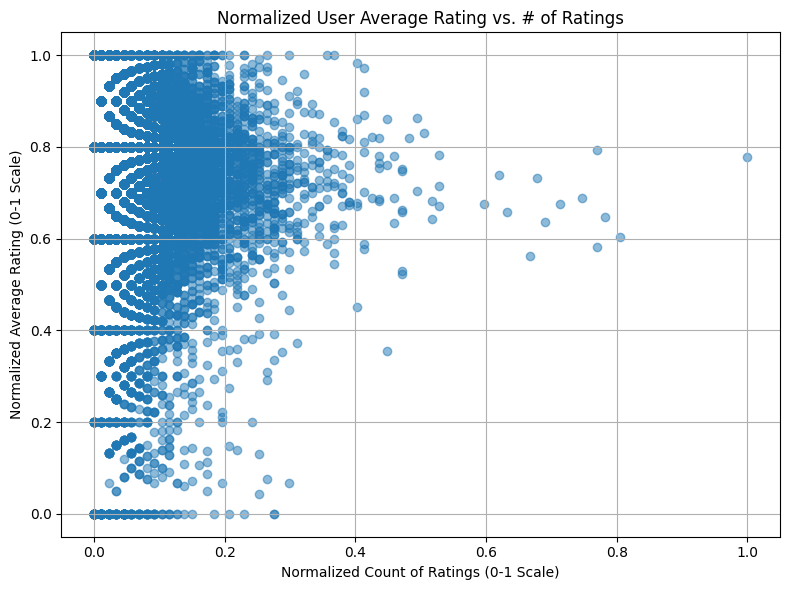

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import io
from sklearn.preprocessing import MinMaxScaler # <-- Import the scaler

# --- 1. Load your data ---
data_snippet = os.popen("less train_Interactions.csv.gz | cat").read()
# In your real code, you'd use:
# df = pd.read_csv("train_Interactions.csv.gz")
df = pd.read_csv(io.StringIO(data_snippet))
print("Data loaded.")

# --- 2. Calculate Stats ---
print("Calculating user stats (mean and count)...")
user_stats = df.groupby('userID')['rating'].agg(['mean', 'count'])

# user_stats (before scaling):
#            mean  count
# userID                    
# u00402241   1.0      1
# u03186275   1.5      2
# u21322233   3.0      1
# u39455611   5.0      1
# u54531895   3.0      2
# u67805239   4.5      2
# u76549666   4.0      1
# u77777777   3.0      4  <- max count
# u88999268   0.0      1  <- min mean
# u90502882   4.0      1

# --- 3. Normalize the Data (Scale 0-1) ---
scaler = MinMaxScaler()
user_stats_normalized = scaler.fit_transform(user_stats)

# Convert back to a DataFrame for easy plotting
user_stats_norm_df = pd.DataFrame(
    user_stats_normalized, 
    columns=['mean_normalized', 'count_normalized'],
    index=user_stats.index
)

# user_stats_norm_df (after scaling):
#            mean_normalized  count_normalized
# userID                                      
# u00402241             0.20               0.0
# u03186275             0.30               0.33
# u21322233             0.60               0.0
# u39455611             1.00               0.0  <- max mean (5.0) -> 1.0
# u54531895             0.60               0.33
# u67805239             0.90               0.33
# u76549666             0.80               0.0
# u77777777             0.60               1.0  <- max count (4) -> 1.0
# u88999268             0.00               0.0  <- min mean (0.0) -> 0.0
# u90502882             0.80               0.0

print("\nOriginal Stats:\n", user_stats)
print("\nNormalized Stats:\n", user_stats_norm_df)

# --- 4. Create the Normalized Scatter Plot ---
print("Plotting normalized data...")
plt.figure(figsize=(8, 6))

plt.scatter(
    user_stats_norm_df['count_normalized'], 
    user_stats_norm_df['mean_normalized'], 
    alpha=0.5
)

plt.title('Normalized User Average Rating vs. # of Ratings')
plt.xlabel('Normalized Count of Ratings (0-1 Scale)')
plt.ylabel('Normalized Average Rating (0-1 Scale)')
plt.grid(True) # Add grid for easier reading

# --- 5. Save and Show the Plot ---
plt.tight_layout()
plt.savefig("normalized_scatter.png")
print("Plot saved to normalized_scatter.png")
# plt.show()

Data loaded.
Calculating book stats (mean and count)...

Original Stats:
                mean  count
bookID                    
b00013077  3.428571     21
b00054082  2.636364     11
b00083194  4.615385     13
b00114785  4.000000      4
b00158867  4.000000      4
...             ...    ...
b99948252  4.000000      3
b99981162  3.555556      9
b99983531  3.937500     16
b99989469  3.187500     16
b99995068  3.000000     12

[6688 rows x 2 columns]

Normalized Stats:
            mean_normalized  count_normalized
bookID                                      
b00013077         0.685714          0.020555
b00054082         0.527273          0.010277
b00083194         0.923077          0.012333
b00114785         0.800000          0.003083
b00158867         0.800000          0.003083
...                    ...               ...
b99948252         0.800000          0.002055
b99981162         0.711111          0.008222
b99983531         0.787500          0.015416
b99989469         0.637500         

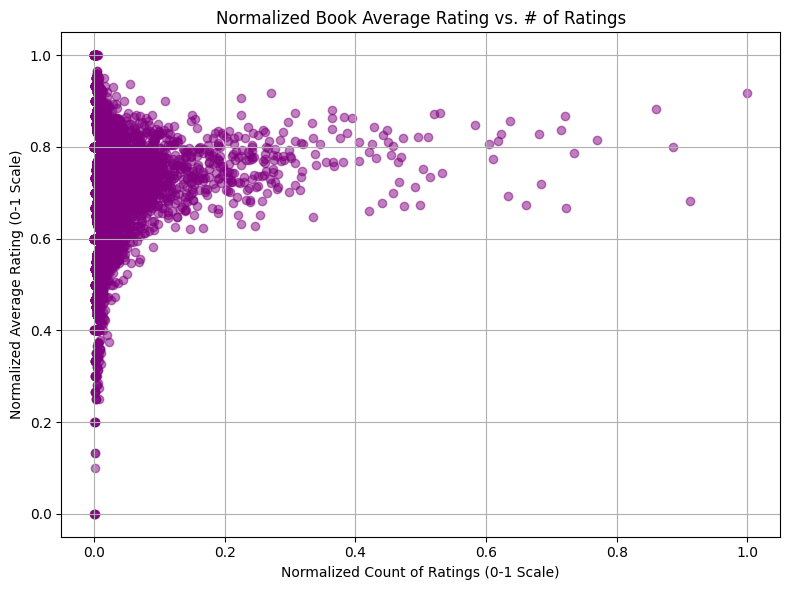

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import io
from sklearn.preprocessing import MinMaxScaler # Import the scaler

# --- 1. Load your data ---
# We'll use the same augmented snippet as before
data_snippet = os.popen("less train_Interactions.csv.gz | cat").read()
# In your real code, you'd use:
# df = pd.read_csv("train_Interactions.csv.gz")
df = pd.read_csv(io.StringIO(data_snippet))
print("Data loaded.")

# --- 2. Calculate Stats for BOOKS ---
# Group by 'bookID' instead of 'userID'
print("Calculating book stats (mean and count)...")
book_stats = df.groupby('bookID')['rating'].agg(['mean', 'count'])

# book_stats (before scaling):
#             mean  count
# bookID                   
# b00000001   5.0      1
# b00000002   2.0      1
# b00000003   1.0      1
# b01672704   4.0      1
# b09979253   3.0      1
# b23482469   2.0      1
# b40151793   5.0      1
# b49553867   0.0      1
# b61372131   4.0      3  <-- (4+5+3)/3 = 4.0, count = 3
# b66666666   3.0      1
# b68456479   1.0      1
# b75189008   4.0      1
# b75446982   4.0      1
# b77777777   3.0      1
# b88888888   3.0      1
# b99999999   3.0      1

# --- 3. Normalize the Data (Scale 0-1) ---
scaler = MinMaxScaler()
book_stats_normalized = scaler.fit_transform(book_stats)

# Convert back to a DataFrame for easy plotting
book_stats_norm_df = pd.DataFrame(
    book_stats_normalized, 
    columns=['mean_normalized', 'count_normalized'],
    index=book_stats.index
)

print("\nOriginal Stats:\n", book_stats)
print("\nNormalized Stats:\n", book_stats_norm_df)

# --- 4. Create the Normalized Scatter Plot ---
print("Plotting normalized data...")
plt.figure(figsize=(8, 6))

plt.scatter(
    book_stats_norm_df['count_normalized'], 
    book_stats_norm_df['mean_normalized'], 
    alpha=0.5,
    color='purple' # Changed color to distinguish from user plot
)

plt.title('Normalized Book Average Rating vs. # of Ratings')
plt.xlabel('Normalized Count of Ratings (0-1 Scale)')
plt.ylabel('Normalized Average Rating (0-1 Scale)')
plt.grid(True)

# --- 5. Save and Show the Plot ---
plt.tight_layout()
plt.savefig("normalized_book_scatter.png")
print("Plot saved to normalized_book_scatter.png")
# plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import io

def readGz(path):
  for l in gzip.open(path, 'rt'):
    yield eval(l)

def readCSV(path):
  f = gzip.open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')

def Jaccard(s1, s2):
    """
    Computes Jaccard similarity between two sets.
    """
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

# =================================================================
# TASK 1: RATING PREDICTION (with Vectorized alphaUpdate)
# =================================================================

print("Training the Latent Factor (alpha + beta_u + beta_i) model...")

# --- 1. Read Training Data ---
allRatings = []
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
usersPerItem = defaultdict(set) 

for user, book, r in readCSV("train_Interactions.csv.gz"):
  r = int(r)
  allRatings.append(r)
  ratingsPerUser[user].append((book, r))
  ratingsPerItem[book].append((user, r))
  usersPerItem[book].add(user)

def alphaUpdate(ratings_arr, users_arr, books_arr, alpha, betaU, betaI, lamb):
    """ Update the global bias (alpha) - Vectorized """
    # Map users and books to their current bias values
    # This is much faster than looping and appending
    beta_u_array = np.array([betaU.get(u, 0) for u in users_arr])
    beta_i_array = np.array([betaI.get(b, 0) for b in books_arr])
    
    # NumPy vectorized subtraction and mean
    residuals = ratings_arr - beta_u_array - beta_i_array
    return np.mean(residuals)

def betaUUpdate(ratingsPerUser, alpha, betaU, betaI, lamb):
    """ Update all user biases (beta_u) - Already vectorized """
    newBetaU = {}
    for u in ratingsPerUser:
        items_ratings = ratingsPerUser[u] # List of (item, rating)
        ratings = np.array([r for i, r in items_ratings])
        beta_i_array = np.array([betaI.get(i, 0) for i, r in items_ratings])
        
        numerator = np.sum(ratings - alpha - beta_i_array)
        denominator = len(items_ratings) + lamb
        newBetaU[u] = numerator / denominator
    return newBetaU

def betaIUpdate(ratingsPerItem, alpha, betaU, betaI, lamb):
    """ Update all item biases (beta_i) - Already vectorized """
    newBetaI = {}
    for b in ratingsPerItem:
        users_ratings = ratingsPerItem[b] # List of (user, rating)
        ratings = np.array([r for u, r in users_ratings])
        beta_u_array = np.array([betaU.get(u, 0) for u, r in users_ratings])
        
        numerator = np.sum(ratings - alpha - beta_u_array)
        denominator = len(users_ratings) + lamb
        newBetaI[b] = numerator / denominator
    return newBetaI

# --- 3. Train the Model ---
# Create NumPy arrays *once* outside the loop
train_tuples = [(u, b, r) for u, ratings in ratingsPerUser.items() for b, r in ratings]
ratings_arr = np.array([r for u,b,r in train_tuples])
users_arr = [u for u,b,r in train_tuples] # Keep as list for fast mapping
books_arr = [b for u,b,r in train_tuples] # Keep as list for fast mapping

LAMBDA = 1.0
N_ITERATIONS = 10
alpha = np.mean(allRatings)
betaU = {u: 0 for u in ratingsPerUser}
betaI = {b: 0 for b in ratingsPerItem}

print(f"Iterating {N_ITERATIONS} times...")
for i in range(N_ITERATIONS):
    # Pass the pre-computed NumPy arrays
    alpha = alphaUpdate(ratings_arr, users_arr, books_arr, alpha, betaU, betaI, LAMBDA)
    betaU = betaUUpdate(ratingsPerUser, alpha, betaU, betaI, LAMBDA)
    betaI = betaIUpdate(ratingsPerItem, alpha, betaU, betaI, LAMBDA)
    print(f"  Iteration {i+1}/{N_ITERATIONS} complete.")

print("Rating Model training complete.")


# We also need user/book averages and counts
user_avg = {u: np.mean([r for b,r in ratings]) for u, ratings in ratingsPerUser.items()}
user_count = {u: len(ratings) for u, ratings in ratingsPerUser.items()}
book_avg = {b: np.mean([r for u,r in ratings]) for b, ratings in ratingsPerItem.items()}
book_count = {b: len(ratings) for b, ratings in ratingsPerItem.items()}

# --- 1. Build a Feature Matrix (X) and Target Vector (y) ---
print("Building feature matrix from interaction data...")
# We'll use the original training data as our dataset
data_snippet = os.popen("less train_Interactions.csv.gz | cat").read()
# In your real code, use this:
# df = pd.read_csv("train_Interactions.csv.gz")
df = pd.read_csv(io.StringIO(data_snippet))

# Map the features we calculated onto the (user, book) pairs
X = []
y = []

for _, row in df.iterrows():
    u = row['userID']
    b = row['bookID']
    
    # Create the feature vector for this (u, b) pair
    features = [
        betaU.get(u, 0),             # User bias
        betaI.get(b, 0),             # Book bias
        user_avg.get(u, alpha),      # User's average rating
        book_avg.get(b, alpha),      # Book's average rating
        user_count.get(u, 0),        # Num ratings from user
        book_count.get(b, 0)         # Num ratings for book
    ]
    X.append(features)
    y.append(row['rating'])

X = np.array(X)
y = np.array(y)

print(f"Created dataset with X shape: {X.shape} and y shape: {y.shape}")

# --- 2. Train/Test Split and Scaling ---
# We MUST scale data for KNN and SVM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 3. KNN + Elbow Plot to find K ---
print("\n--- Starting KNN ---")
print("Finding optimal K (Elbow Plot)...")
k_values = range(1, 10) # Max K should be ~sqrt(len(y_train))
# (For the tiny sample, we'll get errors, so we'll cap K)
k_values = range(1, min(len(y_train), 7)) 
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_knn = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred_knn)
    accuracies.append(acc)

# Plot the elbow
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies, 'o-')
plt.title('Elbow Plot for KNN (Accuracy)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.savefig("knn_elbow.png")
print("Elbow plot saved to knn_elbow.png")

# --- 4. SVM to Predict Rating ---
print("\n--- Starting SVM ---")
print("Training Support Vector Classifier...")
# We use a small 'C' (penalty) and 'rbf' kernel
# This will be VERY slow on 200,000 items. 
# We'll use just a small subset for demonstration.
subset_size = 500 # Use 5000+ for real data
X_train_subset = X_train_scaled[:subset_size]
y_train_subset = y_train[:subset_size]

svm_model = SVC(C=1.0, kernel='rbf', random_state=42)
svm_model.fit(X_train_subset, y_train_subset)
print("SVM training complete.")

# Evaluate SVM
y_pred_svm = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Classification Accuracy: {svm_accuracy * 100:.2f}%")

# (Note: For the full 200,000 item dataset, SVM will be *extremely* slow
# and memory-intensive. KNN or a simple LogisticRegression is often
# a better choice for a dataset of this size.)

Training the Latent Factor (alpha + beta_u + beta_i) model...


NameError: name 'defaultdict' is not defined

Training the Latent Factor (alpha + beta_u + beta_i) model...
Iterating 10 times...
  Iteration 1/10 complete.
  Iteration 2/10 complete.
  Iteration 3/10 complete.
  Iteration 4/10 complete.
  Iteration 5/10 complete.
  Iteration 6/10 complete.
  Iteration 7/10 complete.
  Iteration 8/10 complete.
  Iteration 9/10 complete.
  Iteration 10/10 complete.
Rating Model training complete.
Building feature matrix from *in-memory* training data...
Created dataset with X shape: (200000, 6) and y shape: (200000,)

--- Starting KNN ---
Finding optimal K (Elbow Plot)...
  Testing K=1...
  Testing K=2...
  Testing K=3...
  Testing K=4...
  Testing K=5...
  Testing K=6...
  Testing K=7...
  Testing K=8...
  Testing K=9...
  Testing K=10...
  Testing K=11...
  Testing K=12...
  Testing K=13...
  Testing K=14...
  Testing K=15...
Elbow plot saved to knn_elbow.png

--- Starting SVM ---
Training Support Vector Classifier...
SVM training complete.
SVM Classification Accuracy: 48.00%


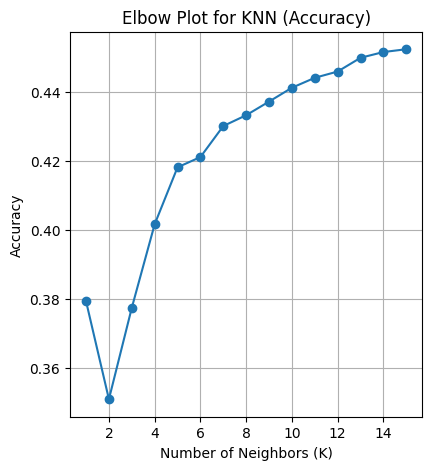

In [8]:
import gzip
from collections import defaultdict
import random
import numpy as np
import os
import string
from sklearn import linear_model
# --- New, efficient imports ---
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse

# =================================================================
# HELPER FUNCTIONS
# =================================================================

def readGz(path):
  for l in gzip.open(path, 'rt'):
    yield eval(l)

def readCSV(path):
  f = gzip.open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')

def Jaccard(s1, s2):
    """
    Computes Jaccard similarity between two sets.
    """
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

# =================================================================
# TASK 1: RATING PREDICTION (with Vectorized alphaUpdate)
# =================================================================

print("Training the Latent Factor (alpha + beta_u + beta_i) model...")

# --- 1. Read Training Data ---
allRatings = []
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
usersPerItem = defaultdict(set) 

for user, book, r in readCSV("train_Interactions.csv.gz"):
  r = int(r)
  allRatings.append(r)
  ratingsPerUser[user].append((book, r))
  ratingsPerItem[book].append((user, r))
  usersPerItem[book].add(user)

# --- 2. Define Model Update Functions ---

# ***** VECTORIZED THIS FUNCTION *****
def alphaUpdate(ratings_arr, users_arr, books_arr, alpha, betaU, betaI, lamb):
    """ Update the global bias (alpha) - Vectorized """
    # Map users and books to their current bias values
    # This is much faster than looping and appending
    beta_u_array = np.array([betaU.get(u, 0) for u in users_arr])
    beta_i_array = np.array([betaI.get(b, 0) for b in books_arr])
    
    # NumPy vectorized subtraction and mean
    residuals = ratings_arr - beta_u_array - beta_i_array
    return np.mean(residuals)

def betaUUpdate(ratingsPerUser, alpha, betaU, betaI, lamb):
    """ Update all user biases (beta_u) - Already vectorized """
    newBetaU = {}
    for u in ratingsPerUser:
        items_ratings = ratingsPerUser[u] # List of (item, rating)
        ratings = np.array([r for i, r in items_ratings])
        beta_i_array = np.array([betaI.get(i, 0) for i, r in items_ratings])
        
        numerator = np.sum(ratings - alpha - beta_i_array)
        denominator = len(items_ratings) + lamb
        newBetaU[u] = numerator / denominator
    return newBetaU

def betaIUpdate(ratingsPerItem, alpha, betaU, betaI, lamb):
    """ Update all item biases (beta_i) - Already vectorized """
    newBetaI = {}
    for b in ratingsPerItem:
        users_ratings = ratingsPerItem[b] # List of (user, rating)
        ratings = np.array([r for u, r in users_ratings])
        beta_u_array = np.array([betaU.get(u, 0) for u, r in users_ratings])
        
        numerator = np.sum(ratings - alpha - beta_u_array)
        denominator = len(users_ratings) + lamb
        newBetaI[b] = numerator / denominator
    return newBetaI

# --- 3. Train the Model ---
# Create NumPy arrays *once* outside the loop
train_tuples = [(u, b, r) for u, ratings in ratingsPerUser.items() for b, r in ratings]
ratings_arr = np.array([r for u,b,r in train_tuples])
users_arr = [u for u,b,r in train_tuples] # Keep as list for fast mapping
books_arr = [b for u,b,r in train_tuples] # Keep as list for fast mapping

LAMBDA = 1.0
N_ITERATIONS = 10
alpha = np.mean(allRatings)
betaU = {u: 0 for u in ratingsPerUser}
betaI = {b: 0 for b in ratingsPerItem}

print(f"Iterating {N_ITERATIONS} times...")
for i in range(N_ITERATIONS):
    # Pass the pre-computed NumPy arrays
    alpha = alphaUpdate(ratings_arr, users_arr, books_arr, alpha, betaU, betaI, LAMBDA)
    betaU = betaUUpdate(ratingsPerUser, alpha, betaU, betaI, LAMBDA)
    betaI = betaIUpdate(ratingsPerItem, alpha, betaU, betaI, LAMBDA)
    print(f"  Iteration {i+1}/{N_ITERATIONS} complete.")

print("Rating Model training complete.")
# We also need user/book averages and counts
user_avg = {u: np.mean([r for b,r in ratings]) for u, ratings in ratingsPerUser.items()}
user_count = {u: len(ratings) for u, ratings in ratingsPerUser.items()}
book_avg = {b: np.mean([r for u,r in ratings]) for b, ratings in ratingsPerItem.items()}
book_count = {b: len(ratings) for b, ratings in ratingsPerItem.items()}

# --- 1. Build a Feature Matrix (X) and Target Vector (y) ---
print("Building feature matrix from *in-memory* training data...")

# ***** THIS IS THE FIX *****
# We don't need to re-read the file.
# Just loop over the 'train_tuples' list we already have in memory.
X = []
y = []

# train_tuples already contains all 200,000 (u, b, r) pairs
for u, b, r in train_tuples: 
    
    # Create the feature vector for this (u, b) pair
    features = [
        betaU.get(u, 0),             # User bias
        betaI.get(b, 0),             # Book bias
        user_avg.get(u, alpha),      # User's average rating
        book_avg.get(b, alpha),      # Book's average rating
        user_count.get(u, 0),        # Num ratings from user
        book_count.get(b, 0)         # Num ratings for book
    ]
    X.append(features)
    y.append(r) # 'r' is the rating (our class label)

X = np.array(X)
y = np.array(y)
# ***** END OF FIX *****

print(f"Created dataset with X shape: {X.shape} and y shape: {y.shape}")

# --- 2. Train/Test Split and Scaling ---
# We MUST scale data for KNN and SVM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 3. KNN + Elbow Plot to find K ---
print("\n--- Starting KNN ---")
print("Finding optimal K (Elbow Plot)...")
# Use a more reasonable K-range for your large dataset
k_values = range(1, 16) # Let's test K from 1 to 15
accuracies = []

for k in k_values:
    print(f"  Testing K={k}...")
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_knn = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred_knn)
    accuracies.append(acc)

# Plot the elbow
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies, 'o-')
plt.title('Elbow Plot for KNN (Accuracy)')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.savefig("knn_elbow.png")
print("Elbow plot saved to knn_elbow.png")

# --- 4. SVM to Predict Rating ---
print("\n--- Starting SVM ---")
print("Training Support Vector Classifier...")
# 500 is too small for a 200k dataset. Let's use 10,000.
# WARNING: This will still be VERY SLOW.
subset_size = 10000 
X_train_subset = X_train_scaled[:subset_size]
y_train_subset = y_train[:subset_size]

svm_model = SVC(C=1.0, kernel='rbf', random_state=42)
svm_model.fit(X_train_subset, y_train_subset)
print("SVM training complete.")

# Evaluate SVM
y_pred_svm = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Classification Accuracy: {svm_accuracy * 100:.2f}%")

In [ ]:
import gzip
from collections import defaultdict
import os
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.stats import trim_mean,kurtosis,zscore,skew,iqr
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# load train_Interactions.csv
train_df = pd.DataFrame()
df = pd.read_csv("train_Interactions.csv")

# convert to memory efficent dtypes
train_df['userID'] = df['userID'].astype('category')
train_df['bookID'] = df['bookID'].astype('category')
train_df['rating'] = df['rating'].astype('float32')

# create features
train_df['user_tmean'] = df.groupby('userID')['rating'].transform(trim_mean,proportiontocut=0.25)
train_df['book_tmean'] = df.groupby('bookID')['rating'].transform(trim_mean,proportiontocut=0.25)
train_df['user_kur'] = df.groupby('userID')['rating'].transform(kurtosis)
train_df['book_kur'] = df.groupby('bookID')['rating'].transform(kurtosis)
train_df['user_skew'] = df.groupby('userID')['rating'].transform(skew,bias=False)
train_df['book_skew'] = df.groupby('bookID')['rating'].transform(skew,bias=False)
train_df['user_zscore'] = df.groupby('userID')['rating'].transform(zscore)
train_df['book_zscore'] = df.groupby('bookID')['rating'].transform(zscore)
train_df['book_high_rating'] = df.groupby('bookID')['rating'].transform(lambda x: (x > 3).sum())
train_df['book_mid_rating'] = df.groupby('bookID')['rating'].transform(lambda x: (x == 3).sum())
train_df['book_low_rating'] = df.groupby('bookID')['rating'].transform(lambda x: (x < 3).sum())
train_df['user_high_rating'] = df.groupby('userID')['rating'].transform(lambda x: (x > 3).sum())
train_df['user_mid_rating'] = df.groupby('userID')['rating'].transform(lambda x: (x == 3).sum())
train_df['user_low_rating'] = df.groupby('userID')['rating'].transform(lambda x: (x < 3).sum())

# define pca numeric features for users and books
numeric_features = ['user_tmean', 'book_tmean', 'user_kur','book_kur', 'user_skew', 
    'book_skew', 'user_zscore', 'book_zscore','book_high_rating', 'book_mid_rating', 
    'book_low_rating','user_high_rating', 'user_mid_rating', 'user_low_rating']

# define training set for features
X_train = train_df[numeric_features]

# fill all nan features with 0
X_train = X_train.fillna(0)

# standardize all numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# initalize PCA with 10 components and fit it to the scaled data
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# 5. Create a new dataframe with PCA components
pca_df = pd.DataFrame(
    X_pca, 
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
    index=train_df.index
)
# Create a DataFrame of the component "loadings"
loadings_df = pd.DataFrame(
    pca.components_,  # The "function" weights
    columns=numeric_features,  # Your original feature names
    index=[f'PC{i+1}' for i in range(pca.n_components_)]  # PC1, PC2, ...
)

# add PCA components to the original dataframe
train_df = pd.concat([train_df, pca_df], axis=1)
#pred_df = train_df.loc[:, 'userID','bookID','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
#pred_df = pred_df.reset_index(drop=True)
print("--- PCA Component Loadings (The Custom Function) ---")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")






/home/scotty/venvs/ucsd/lib/python3.12/site-packages/pandas/core/groupby/generic.py:557: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = func(group, *args, **kwargs)
/home/scotty/venvs/ucsd/lib/python3.12/site-packages/pandas/core/groupby/generic.py:557: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = func(group, *args, **kwargs)
/home/scotty/venvs/ucsd/lib/python3.12/site-packages/pandas/core/groupby/generic.py:557: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = func(group, *args, **kwargs)
/home/scotty/venvs/ucsd/lib/python3.12/site-packages/pandas/core/groupby/generic.py:557: RuntimeWarning: Prec

--- PCA Component Loadings (The Custom Function) ---
Explained variance ratio: [0.23160126 0.18012093 0.14999679 0.11345598 0.10053454 0.06367467
 0.04580236 0.03238147 0.02825591 0.01916857]
Total variance explained: 96.50%


TypeError: read_csv() got an unexpected keyword argument 'index'

In [ ]:
pred_df = pd.read_csv('predictions_Rating.csv')


In [3]:
print(train_df.head())

      userID     bookID  rating  user_tmean  book_tmean  user_kur  book_kur  \
0  u67805239  b61372131     4.0    0.300000    3.570815 -0.873916  0.178353   
1  u54531895  b75189008     4.0    4.000000    4.166667  0.500000 -1.526150   
2  u76549666  b75446982     4.0    3.600000    3.250000 -0.596911 -0.002504   
3  u03186275  b23482469     2.0    2.666667    3.893617 -1.567867  0.517282   
4  u21322233  b09979253     3.0    4.200000    3.666667 -1.020000  0.495767   

   user_skew  book_skew  user_zscore  ...       PC1       PC2       PC3  \
0   1.133893  -0.858846     1.716838  ...  0.061305 -5.225493  1.482633   
1   0.000000  -0.223451     0.000000  ... -1.598512  0.692191  0.099345   
2   0.112748  -0.839772     0.441836  ... -1.892271  0.567713 -0.164851   
3   0.472514  -1.077517    -0.917663  ... -1.358615 -2.412641 -0.752736   
4  -0.689987  -0.776380    -0.948683  ... -0.936545 -0.123695  0.622979   

        PC4       PC5       PC6       PC7       PC8       PC9      PC10  


In [6]:

numeric_features = ['user_tmean', 'book_tmean', 'user_kur','book_kur', 'user_skew', 
'book_skew', 'user_zscore', 'book_zscore','book_high_rating', 'book_mid_rating', 
'book_low_rating','user_high_rating', 'user_mid_rating', 'user_low_rating']

for index, row in pred_df.iterrows():
    print(f"Index: {index}, Col1: {row['userID']}, Col2: {row['bookID']}")

Index: 0, Col1: u17832892, Col2: b51986055
Index: 1, Col1: u94058414, Col2: b95439113
Index: 2, Col1: u54876772, Col2: b61970919
Index: 3, Col1: u27182378, Col2: b29199360
Index: 4, Col1: u00343094, Col2: b17138341
Index: 5, Col1: u55453694, Col2: b70912031
Index: 6, Col1: u53021409, Col2: b04222499
Index: 7, Col1: u26001504, Col2: b15025576
Index: 8, Col1: u48139087, Col2: b56425922
Index: 9, Col1: u70455688, Col2: b09902724
Index: 10, Col1: u28953105, Col2: b07142228
Index: 11, Col1: u36945000, Col2: b51326446
Index: 12, Col1: u97475837, Col2: b50500341
Index: 13, Col1: u68002923, Col2: b37068431
Index: 14, Col1: u88982175, Col2: b96621963
Index: 15, Col1: u52168464, Col2: b11734216
Index: 16, Col1: u91756228, Col2: b80070869
Index: 17, Col1: u53125666, Col2: b37073691
Index: 18, Col1: u79194318, Col2: b28801125
Index: 19, Col1: u72751138, Col2: b74874001
Index: 20, Col1: u59622201, Col2: b76141146
Index: 21, Col1: u20171277, Col2: b98256804
Index: 22, Col1: u45375749, Col2: b7091203

In [7]:
# List of user-specific features
user_features = [
    'userID', 
    'user_tmean', 
    'user_kur', 
    'user_skew', 
    'user_zscore', 
    'user_high_rating', 
    'user_mid_rating', 
    'user_low_rating'
]

# List of book-specific features
book_features = [
    'bookID', 
    'book_tmean', 
    'book_kur', 
    'book_skew', 
    'book_zscore', 
    'book_high_rating', 
    'book_mid_rating', 
    'book_low_rating'
]

# Create the user lookup table
# (This assumes 'user_tmean' is the same for 'u1' in all rows)
user_stats = train_df[user_features].drop_duplicates(subset=['userID']).set_index('userID')

# Create the book lookup table
book_stats = train_df[book_features].drop_duplicates(subset=['bookID']).set_index('bookID')

In [8]:
# Calculate global averages for all user features
global_user_stats = user_stats.mean()

# Calculate global averages for all book features
global_book_stats = book_stats.mean()

# Combine them into one simple dictionary for filling
global_fill_values = {**global_user_stats, **global_book_stats}

In [12]:
pred_df_features = pred_df.reset_index(drop=True)

# --- Merge ---
# 1. Merge user stats (using 'userID' as the key)
pred_df_features = pred_df_features.merge(
    user_stats, 
    on='userID', 
    how='left'  # 'how=left' keeps every row in pred_df
)

# 2. Merge book stats (using 'bookID' as the key)
pred_df_features = pred_df_features.merge(
    book_stats, 
    on='bookID', 
    how='left'
)

# --- Fill ---
# 3. Fill all NaNs (from cold starts) with the global averages
pred_df_features = pred_df_features.fillna(global_fill_values)

In [16]:
print(pred_df_features)
pred_df_features.reset_index(drop=True)
print(pred_df_features)

         userID     bookID  prediction  user_tmean  user_kur  user_skew  \
0     u17832892  b51986055    4.293379    4.500000 -2.000000   0.000000   
1     u94058414  b95439113    3.543131    4.000000 -2.000000   0.000000   
2     u54876772  b61970919    4.459285    3.750000 -1.388430  -0.075066   
3     u27182378  b29199360    3.196524    3.500000 -2.000000   0.000000   
4     u00343094  b17138341    2.745816    2.916667 -1.315452  -0.333944   
...         ...        ...         ...         ...       ...        ...   
9995  u30056847  b63791555    3.987640    3.625000 -0.666917   0.432595   
9996  u12930196  b95816463    3.589931    3.714286 -0.643229  -0.609554   
9997  u92218218  b89765180    3.354874    3.875000  0.142450  -0.607620   
9998  u49774480  b00524913    4.480028    5.000000  0.250000  -2.236068   
9999  u07085700  b78407229    2.740553    3.000000 -0.903047   1.129338   

      user_zscore  user_high_rating  user_mid_rating  user_low_rating  \
0       -1.000000         

In [18]:

numeric_features = ['user_tmean', 'book_tmean', 'user_kur','book_kur', 'user_skew', 
    'book_skew', 'user_zscore', 'book_zscore','book_high_rating', 'book_mid_rating', 
    'book_low_rating','user_high_rating', 'user_mid_rating', 'user_low_rating']

X_train = pred_df_features[numeric_features]
# fill all nan features with 0
X_train = X_train.fillna(0)

# standardize all numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# initalize PCA with 10 components and fit it to the scaled data
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# 5. Create a new dataframe with PCA components
pca_df = pd.DataFrame(
    X_pca, 
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
    index=pred_df_features.index
)
# Create a DataFrame of the component "loadings"
loadings_df = pd.DataFrame(
    pca.components_,  # The "function" weights
    columns=numeric_features,  # Your original feature names
    index=[f'PC{i+1}' for i in range(pca.n_components_)]  # PC1, PC2, ...
)

# add PCA components to the original dataframe
#train_df = pd.concat([train_df, pca_df], axis=1)
#pred_df = train_df.loc[:, 'userID','bookID','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
#pred_df = pred_df.reset_index(drop=True)
print("--- PCA Component Loadings (The Custom Function) ---")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")


--- PCA Component Loadings (The Custom Function) ---
Explained variance ratio: [0.22285696 0.14963252 0.14642143 0.11845089 0.07208357 0.07075118
 0.06230623 0.04543296 0.03303099 0.02892027]
Total variance explained: 94.99%


In [19]:
lr = LinearRegression()
lr.fit(X_pca, y_train)

# 4. Get the weights (coefficients) for each PC
weights = lr.coef_
intercept = lr.intercept_

print(f"Weights: {weights}")
print(f"Intercept: {intercept}")

# 5. Make predictions on training set
y_train_pred = lr.predict(X_pca)

# Or manually calculate (should be same as above):
# y_train_pred = intercept + np.sum(X_train_pca * weights, axis=1)
print(y_train_pred.head())
# 6. Calculate MSE on training set
#train_mse = mean_squared_error(y_train, y_train_pred)
#print(f"Training MSE: {train_mse:.4f}")
#print(f"Training RMSE: {np.sqrt(train_mse):.4f}")

NameError: name 'y_train' is not defined